# Série temporelle quotidienne – Demande globale (ARIMA, Sarima, LSTM)

# predire la demande au fil du temps 

C:\Users\user\AppData\Local\Temp\ipykernel_24160\2873159290.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\user\AppData\Local\Temp\ipykernel_24160\2873159290.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Quantite_lissee'] = df['Quantite_lissee'].fillna(method='bfill').fillna(method='ffill')
c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
🧬 LSTM (test)
MAE  : 2.43
RMSE : 4.21
R²   : 0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1

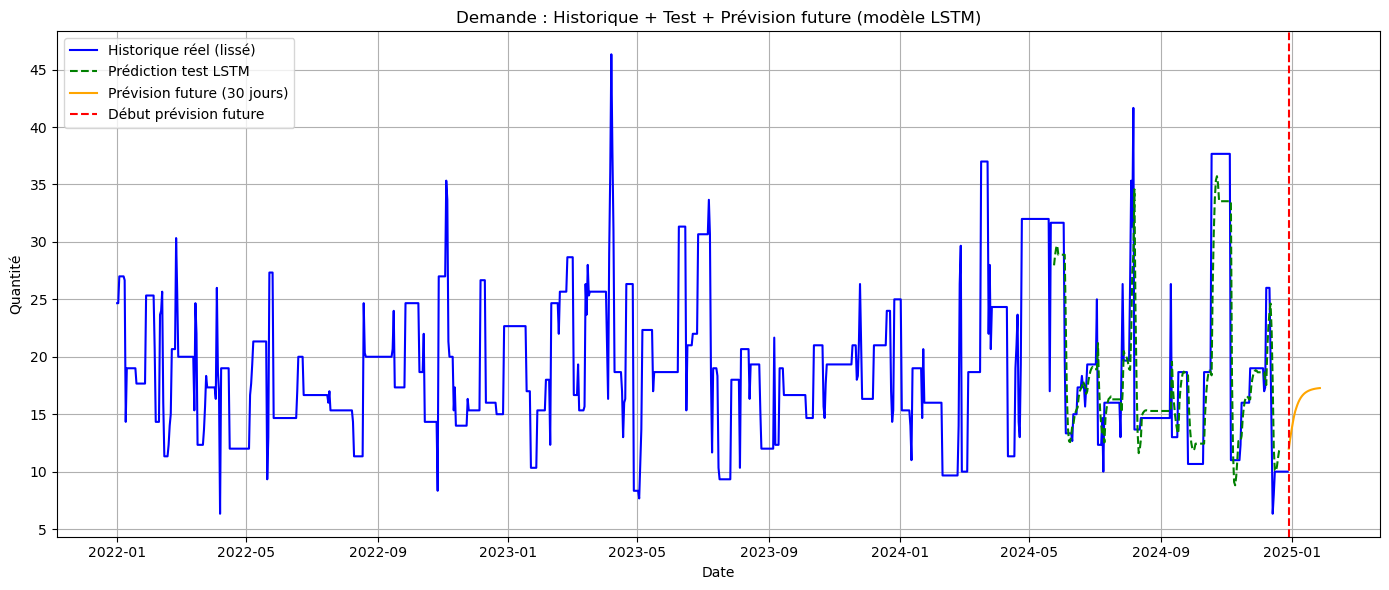

In [3]:
import pandas as pd
import numpy as np
import pyodbc
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Connexion SQL
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-8C3VSOH;'
    'DATABASE=SuplyChain_DataWarehouse;'
    'Trusted_Connection=yes;'
)

# Requête SQL
query = '''
SELECT 
    d.Full_Date,
    SUM(fs.Quantite) AS Quantite_lissee
FROM 
    Fact_Sales fs
JOIN 
    Dim_Date d ON fs.Date_FK = d.Date_PK
GROUP BY 
    d.Full_Date
ORDER BY 
    d.Full_Date;
'''
df = pd.read_sql(query, conn)
conn.close()


#3.  Préparation et lissage des données
# Mise en forme

df['Full_Date'] = pd.to_datetime(df['Full_Date'])
df.set_index('Full_Date', inplace=True)
df = df.asfreq('D')
df['Quantite_lissee'] = df['Quantite_lissee'].rolling(window=3, center=True).mean() #ait une moyenne mobile sur 3 jours pour lisser les pics
df['Quantite_lissee'] = df['Quantite_lissee'].fillna(method='bfill').fillna(method='ffill')

# Préparation LSTM
train_size = int(len(df) * 0.8)
train = df['Quantite_lissee'][:train_size]
test = df['Quantite_lissee'][train_size:]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df['Quantite_lissee'].values.reshape(-1, 1))

#Tu crées des séquences de 7 jours → pour prédire le 8e jour.
# Séquences
seq_len = 7
X, y = [], []
for i in range(seq_len, train_size):
    X.append(scaled_data[i-seq_len:i])
    y.append(scaled_data[i])
X, y = np.array(X), np.array(y)

# Modèle LSTM
model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_len, 1)), #50 neurones 1 pour la sortie
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=25, verbose=0) #je l entraine sur 25 époques 

# Prédictions sur test
X_test = []
for i in range(train_size, len(scaled_data) - seq_len):
    X_test.append(scaled_data[i-seq_len:i])
X_test = np.array(X_test)
pred_lstm = model.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)
test_evaluated = test[:len(pred_lstm)]

# Évaluation
mae_lstm = mean_absolute_error(test_evaluated, pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(test_evaluated, pred_lstm))  # Correction ici
r2_lstm = r2_score(test_evaluated, pred_lstm)

print("🧬 LSTM (test)")
print(f"MAE  : {mae_lstm:.2f}")
print(f"RMSE : {rmse_lstm:.2f}")
print(f"R²   : {r2_lstm:.2f}")

# Prévision future (30 jours)
last_seq = scaled_data[-seq_len:]
future_preds = []
input_seq = last_seq.copy()

for _ in range(30):
    pred = model.predict(input_seq.reshape(1, seq_len, 1))
    future_preds.append(pred[0][0])
    input_seq = np.append(input_seq[1:], pred, axis=0)

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
future_dates = pd.date_range(start=df.index[-1] + timedelta(days=1), periods=30)

#  Fusion des données dans un seul DataFrame
df_all = pd.concat([
    pd.DataFrame({
        'Date_Prediction': test_evaluated.index,
        'Demande_Predite_LSTM': pred_lstm.flatten()
    }),
    pd.DataFrame({
        'Date_Prediction': future_dates,
        'Demande_Predite_LSTM': future_preds.flatten()
    })
], ignore_index=True)

# Export SQL pour Power BI
engine = create_engine("mssql+pyodbc://localhost/SuplyChain_DataWarehouse?driver=ODBC+Driver+17+for+SQL+Server")
df_all.to_sql("Prevision_Demande_LSTM", con=engine, if_exists="replace", index=False)
print(" Prévisions totales (test + 30 jours futurs) envoyées dans 'Prevision_Demande_LSTM'")

# Visualisation
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Quantite_lissee'], label='Historique réel (lissé)', color='blue')
plt.plot(test_evaluated.index, pred_lstm, label='Prédiction test LSTM', linestyle='--', color='green')
plt.plot(future_dates, future_preds, label='Prévision future (30 jours)', linestyle='-', color='orange')
plt.axvline(x=future_dates[0], color='red', linestyle='dashed', label='Début prévision future')
plt.title("Demande : Historique + Test + Prévision future (modèle LSTM)")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_6232\1028190663.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\user\AppData\Local\Temp\ipykernel_6232\1028190663.py:37: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Quantite_lissee'] = df['Quantite_lissee'].fillna(method='bfill').fillna(method='ffill')
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


📈 SARIMA (test)
MAE  : 9.31
RMSE : 11.56
R²   : -0.01
✅ Prévisions SARIMA (test + 30 jours futurs) envoyées dans 'Prevision_Demande_SARIMA'


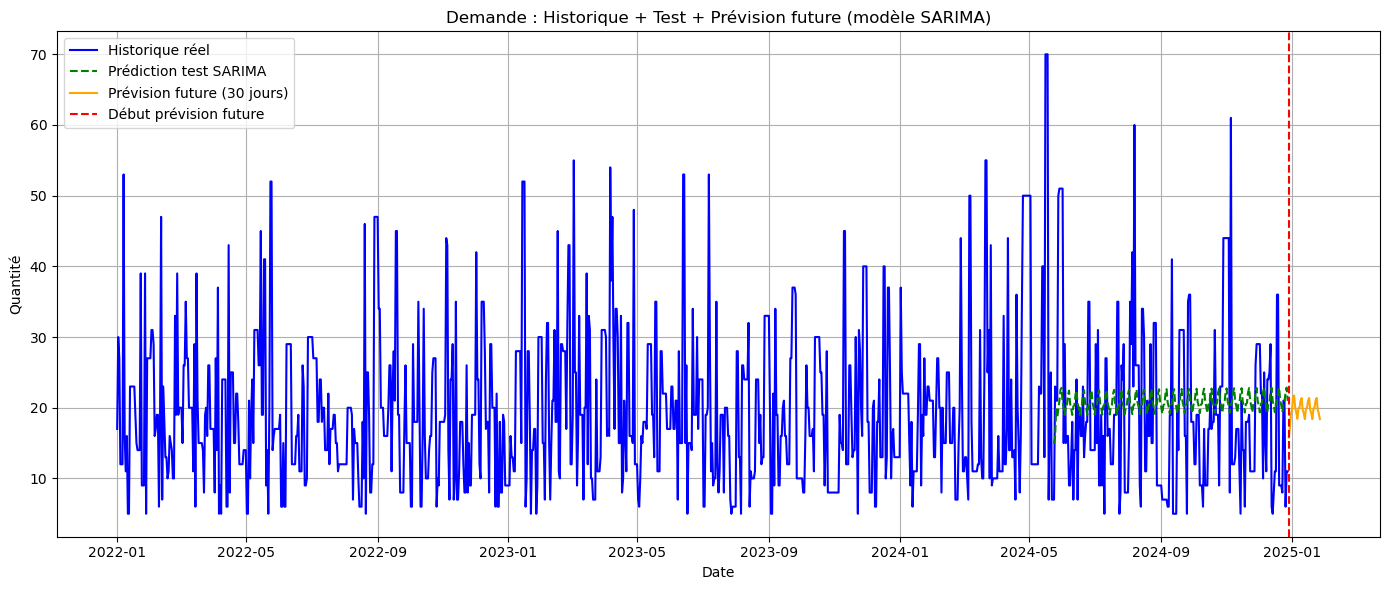

In [ ]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine

# Connexion SQL
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-8C3VSOH;'
    'DATABASE=SuplyChain_DataWarehouse;'
    'Trusted_Connection=yes;'
)

# Requête SQL
query = '''
SELECT 
    d.Full_Date,
    SUM(fs.Quantite) AS Quantite_lissee
FROM 
    Fact_Sales fs
JOIN 
    Dim_Date d ON fs.Date_FK = d.Date_PK
GROUP BY 
    d.Full_Date
ORDER BY 
    d.Full_Date;
'''
df = pd.read_sql(query, conn)
conn.close()

# Mise en forme
df['Full_Date'] = pd.to_datetime(df['Full_Date'])
df.set_index('Full_Date', inplace=True)
df = df.asfreq('D')
df['Quantite_lissee'] = df['Quantite_lissee'].fillna(method='bfill').fillna(method='ffill')

# Split train/test
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Modèle SARIMA
model = SARIMAX(train['Quantite_lissee'], 
                order=(1,1,1),  # paramètres ARIMA (AutoRegressive, Integrated, Moving Average)
                seasonal_order=(1,1,1,7), #effet hebdomadaire (période = 7 jours)
                enforce_stationarity=False, 
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Prédiction sur test
pred_test = model_fit.forecast(steps=len(test))

# Évaluation
mae_sarima = mean_absolute_error(test['Quantite_lissee'], pred_test)
rmse_sarima = mean_squared_error(test['Quantite_lissee'], pred_test, squared=False)
r2_sarima = r2_score(test['Quantite_lissee'], pred_test)

print("📈 SARIMA (test)")
print(f"MAE  : {mae_sarima:.2f}")
print(f"RMSE : {rmse_sarima:.2f}")
print(f"R²   : {r2_sarima:.2f}")

# Re-entrainement complet pour prédire futur
model_full = SARIMAX(df['Quantite_lissee'], 
                     order=(1,1,1), 
                     seasonal_order=(1,1,1,7),
                     enforce_stationarity=False,
                     enforce_invertibility=False)
model_full_fit = model_full.fit(disp=False)

# Prévision future (30 jours)
future_preds = model_full_fit.forecast(steps=30)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

# 📦 Fusion Historique + Test + Futur
df_all = pd.concat([
    pd.DataFrame({
        'Date_Prediction': test.index,
        'Demande_Predite_SARIMA': pred_test
    }),
    pd.DataFrame({
        'Date_Prediction': future_dates,
        'Demande_Predite_SARIMA': future_preds
    })
], ignore_index=True)

# Export SQL
engine = create_engine("mssql+pyodbc://localhost/SuplyChain_DataWarehouse?driver=ODBC+Driver+17+for+SQL+Server")
df_all.to_sql("Prevision_Demande_SARIMA", con=engine, if_exists="replace", index=False)
print("✅ Prévisions SARIMA (test + 30 jours futurs) envoyées dans 'Prevision_Demande_SARIMA'")

# Visualisation
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Quantite_lissee'], label='Historique réel', color='blue')
plt.plot(test.index, pred_test, label='Prédiction test SARIMA', linestyle='--', color='green')
plt.plot(future_dates, future_preds, label='Prévision future (30 jours)', linestyle='-', color='orange')
plt.axvline(x=future_dates[0], color='red', linestyle='dashed', label='Début prévision future')
plt.title("Demande : Historique + Test + Prévision future (modèle SARIMA)")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_31476\2241085297.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)
C:\Users\user\AppData\Local\Temp\ipykernel_31476\2241085297.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Quantite_lissee'] = df['Quantite_lissee'].fillna(method='bfill').fillna(method='ffill')
c:\Users\user\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


📈 ARIMA avec prédiction dynamique (test)
MAE  : 1.57
RMSE : 3.94
R²   : 0.75
✅ Prévisions ARIMA (test + 30 jours futurs) envoyées dans 'Prevision_Demande_ARIMA'


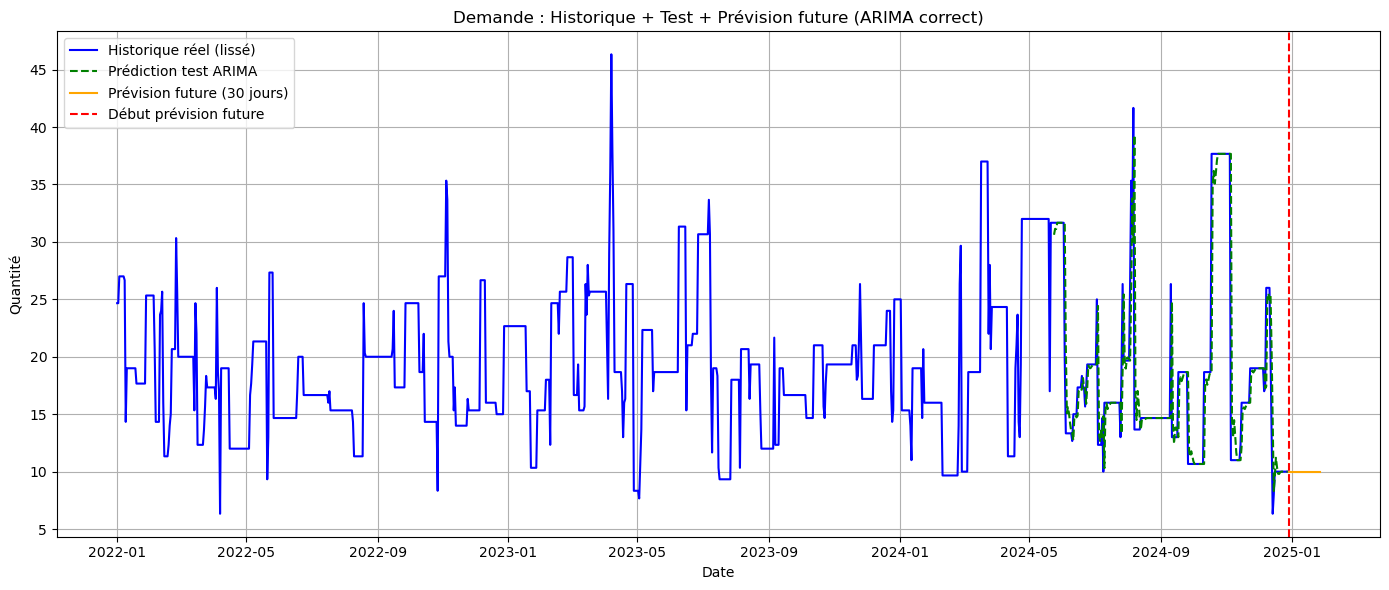

In [ ]:
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine

# Connexion SQL
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-8C3VSOH;'
    'DATABASE=SuplyChain_DataWarehouse;'
    'Trusted_Connection=yes;'
)

# Requête SQL
query = '''
SELECT 
    d.Full_Date,
    SUM(fs.Quantite) AS Quantite_lissee
FROM 
    Fact_Sales fs
JOIN 
    Dim_Date d ON fs.Date_FK = d.Date_PK
GROUP BY 
    d.Full_Date
ORDER BY 
    d.Full_Date;
'''
df = pd.read_sql(query, conn)
conn.close()

# Préparation
df['Full_Date'] = pd.to_datetime(df['Full_Date'])
df.set_index('Full_Date', inplace=True)
df = df.asfreq('D')
df['Quantite_lissee'] = df['Quantite_lissee'].rolling(window=3, center=True).mean()
df['Quantite_lissee'] = df['Quantite_lissee'].fillna(method='bfill').fillna(method='ffill')

# Split train/test
train_size = int(len(df) * 0.8)
train = df['Quantite_lissee'].iloc[:train_size]
test = df['Quantite_lissee'].iloc[train_size:]

# Construction dynamique
history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0)) #5 dernières observations  appique une differenciation de 1 //ne prend pas en compte les erreurs passées (q=0)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test.iloc[t])

# Évaluation
mae_arima = mean_absolute_error(test, predictions)
rmse_arima = mean_squared_error(test, predictions, squared=False)
r2_arima = r2_score(test, predictions)

print(" ARIMA avec prédiction dynamique (test)")
print(f"MAE  : {mae_arima:.2f}")
print(f"RMSE : {rmse_arima:.2f}")
print(f"R²   : {r2_arima:.2f}")

# Entrainement complet pour prédiction future
model_full = ARIMA(df['Quantite_lissee'], order=(5,1,0))
model_full_fit = model_full.fit()

# Prévision 30 jours
future_preds = model_full_fit.forecast(steps=30)
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

#  Fusion pour export
df_all = pd.concat([
    pd.DataFrame({
        'Date_Prediction': test.index,
        'Demande_Predite_ARIMA': predictions
    }),
    pd.DataFrame({
        'Date_Prediction': future_dates,
        'Demande_Predite_ARIMA': future_preds
    })
], ignore_index=True)

# Export SQL
engine = create_engine("mssql+pyodbc://localhost/SuplyChain_DataWarehouse?driver=ODBC+Driver+17+for+SQL+Server")
df_all.to_sql("Prevision_Demande_ARIMA", con=engine, if_exists="replace", index=False)

print(" Prévisions ARIMA (test + 30 jours futurs) envoyées dans 'Prevision_Demande_ARIMA'")

# Visualisation
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Quantite_lissee'], label='Historique réel (lissé)', color='blue')
plt.plot(test.index, predictions, label='Prédiction test ARIMA', linestyle='--', color='green')
plt.plot(future_dates, future_preds, label='Prévision future (30 jours)', linestyle='-', color='orange')
plt.axvline(x=future_dates[0], color='red', linestyle='dashed', label='Début prévision future')
plt.title("Demande : Historique + Test + Prévision future (ARIMA correct)")
plt.xlabel("Date")
plt.ylabel("Quantité")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
